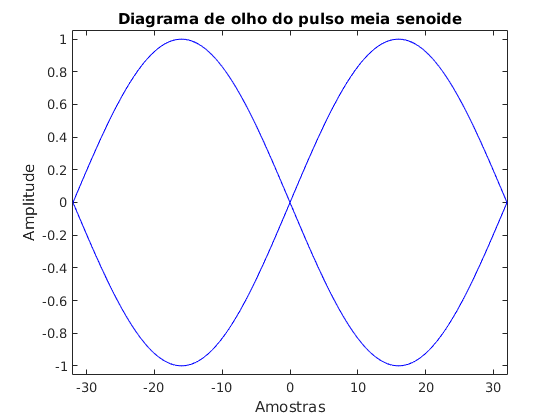

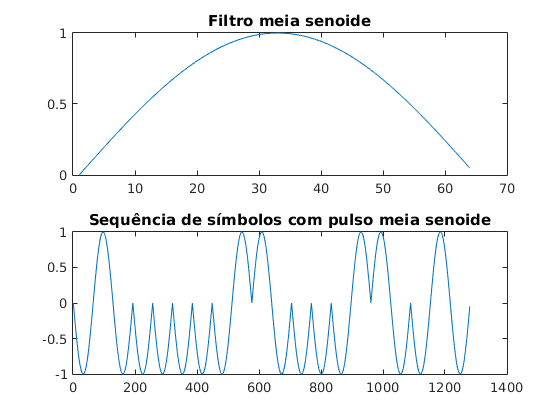

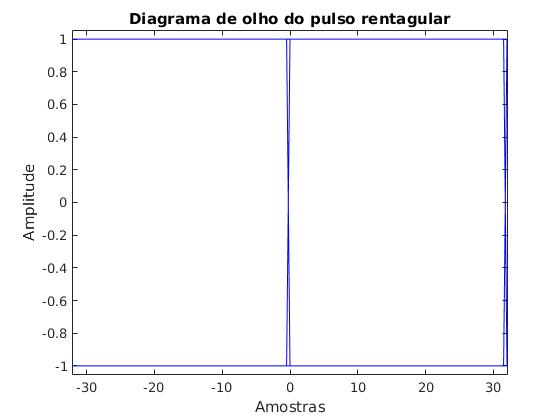

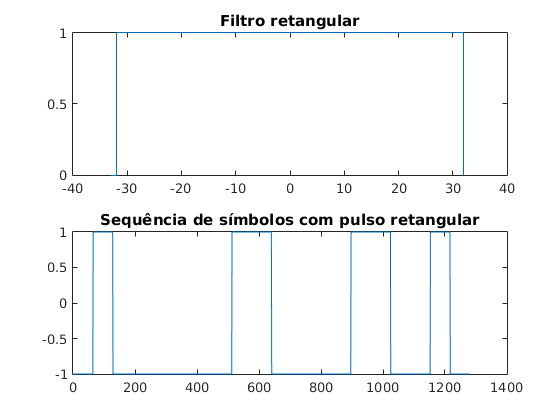

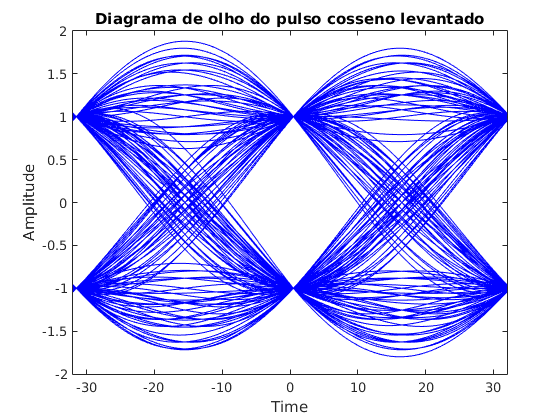

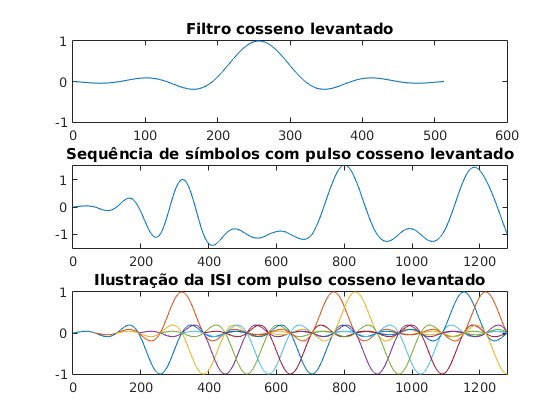

In [3]:
from matplotlib import pylab as plt
import numpy as np
from scipy import stats

def rcosfir(r, N_T, rate, T):
    if isinstance(N_T, int):
        N_T = np.hstack((N_T, N_T))

    N_T[0] = -abs(N_T[0])
    time_T = np.arange(0, 1/rate, max(N_T[1], abs(N_T[0])))
    b=firrcos(rate*(N_T[1]-N_T[0]),1/(2*T),r,rate/T,-N_T[0]*rate)*rate

    return b

def firrcos(N, fc, R, fs, delay):
    # Check if the filter order is a positive, even integer
    assert (N >= 0) and (N % 2 == 0)
    # Cast to enforce Precision Rules

    L = N+1 # Length of window

    # Check for valid cutoff frequency
    assert 0 < fc < fs/2

    # Check for valid rolloff values
    # check if input arguments are valid 
    # assert 0 >= R <= 1
    # check for range of input arguments
    assert (fc + R*fc) <= fs/2

    assert 0 <= delay <= L

    n = (np.arange(L)-delay) / fs

    return normal_design(n,fc,fs,R)

def normal_design(n,fc,fs,R):
    mask = np.isclose(abs(abs(4*R*fc*n) - 1.0), 0)
    b = np.zeros(n.shape)
    if mask.any():
        nind = n[mask]
        b[mask] = np.sinc(2*fc*nind)/fs \
                * np.cos(2*np.pi*R*fc*nind) \
                / (1.0 - (4*R*fc*nind)**2)

    b[np.invert(mask)] = R / (2*fs) * np.sin(np.pi/(2*R))

    return 2*fc*b

def eyediagram(x, n, period=None, offset=None):
    """Draw the eye diagram using all parts of the given signal x"""
    if period is None:
        period = n
    if offset is None:
        offset = n
    t = np.tile(np.arange(-period/2, period/2), (n, 1))
    if len(x) % n > 0:
        x = np.hstack((x, np.zeros(n - (len(x) % n))))
    y = np.reshape(x, (-1, n)).T
    plt.figure()
    plt.plot(t, y, 'b-')
    plt.ylim((-np.max(np.abs(x)),np.max(np.abs(x))))
    plt.tight_layout()

def upsample(signal, rate):
    ret = np.zeros(rate*len(signal))
    ret[::rate] = signal
    return ret

peSim = 64                                        # Período do símbolo (amostras/símbolo)
nsCL = 4                                          # Número de símbolos o cosseno levantado se espalhará (ISI)
roff = 0.25                                       # Fator de decaimento do cosseno levantado
nSimbs = 400                                      # Número de símbolos transmitidos 
vtSim = 2*stats.randint.rvs(0, 2, size=nSimbs)-1  # Símbolos
dup = upsample(vtSim, peSim)                      # Símbolos (sobreamostragem)
hrc = rcosfir(roff, nsCL, peSim, 1)     # Cosseno levantado
yrcosAll = np.convolve(dup, hrc)                         # Símbolos transmitidos com o cosseno levantado
yrcos = yrcosAll[2*nsCL*peSim-1:-2*nsCL*peSim] # Trem de pulso cosseno levantado
# Configuração dos gráficos no tempo
nSim2Plot = 20                                    # Número de símbolos para o gráfico no tempo
# gráfico pulso cosseno levantado
plt.subplot(3, 1, 1)
plt.plot(hrc)
plt.title('Filtro cosseno levantado')
plt.subplot(3, 1, 2)
plt.plot(yrcosAll[:nSim2Plot*peSim])
plt.title('Sequência de símbolos com pulso cosseno levantado')
plt.axis([0, peSim*nSim2Plot, -1.5, 1.5])
plt.subplot(3, 1, 3)
t = np.arange(len(hrc))
for i, symbol in enumerate(vtSim):
    plt.plot(t + i*peSim, symbol*hrc)
plt.axis([0, peSim*nSim2Plot, -1, 1])
plt.title('Ilustração da ISI com pulso cosseno levantado')
# Diagrama de olho
eyediagram(yrcos, 2*peSim, peSim)                  # Diagrama de olho do cosseno levantado
plt.title('Diagrama de olho do pulso cosseno levantado')
#
# Pulso retangular
hT = np.ones(1, peSim)   # Pulso retangular do transmissor (NRZ)
# Aplicando o pulso a sequência de símbolos 
ynrzAll = conv(dup, hT)                            # Símbolos transmitidos com pulso retangular
ynrz = ynrzAll[:-peSim]                            # retira o último símbolo  
# gráfico pulso rentangular
plt.figure()
plt.subplot(2, 1, 1)
thT = np.arange(-peSim/2, peSim/2)
stairs(
    np.hstack(([thT[0]-1], thT, [thT[-1]+1])),
    np.hstack(([0], hT, [0])))


plt.title('Filtro retangular')
plt.subplot(2, 1, 2)                                    # Número de símbolos para o gráfico no tempo
plt.plot(ynrzAll[:nSim2Plot*peSim])
plt.title('Sequência de símbolos com pulso retangular')
# Diagrama de olho
eyediagram(ynrz, 2*peSim, peSim)                   # Diagrama de olho do cosseno levantado
plt.title('Diagrama de olho do pulso rentagular')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
#
# Pulso meia senoide
hSin = sin(pi*np.arange(peSim)/peSim)   # Pulso meia senoide
# Aplicando o pulso a sequência de símbolos 
ysinAll = conv(dup, hSin)                          # Símbolos transmitidos com pulso meia senoide
ysin = ysinAll[:-peSim]                     # retira o último símbolo  
# gráfico pulso meia senoide
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(hSin)
plt.title('Filtro meia senoide')
plt.subplot(2, 1, 2)                                    # Número de símbolos para o gráfico no tempo
plt.plot(ysinAll[:nSim2Plot*peSim])
plt.title('Sequência de símbolos com pulso meia senoide')
# Diagrama de olho
eyediagram(ysin, 2*peSim, peSim)                   # Diagrama de olho do pulso meia senoide
plt.title('Diagrama de olho do pulso meia senoide')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

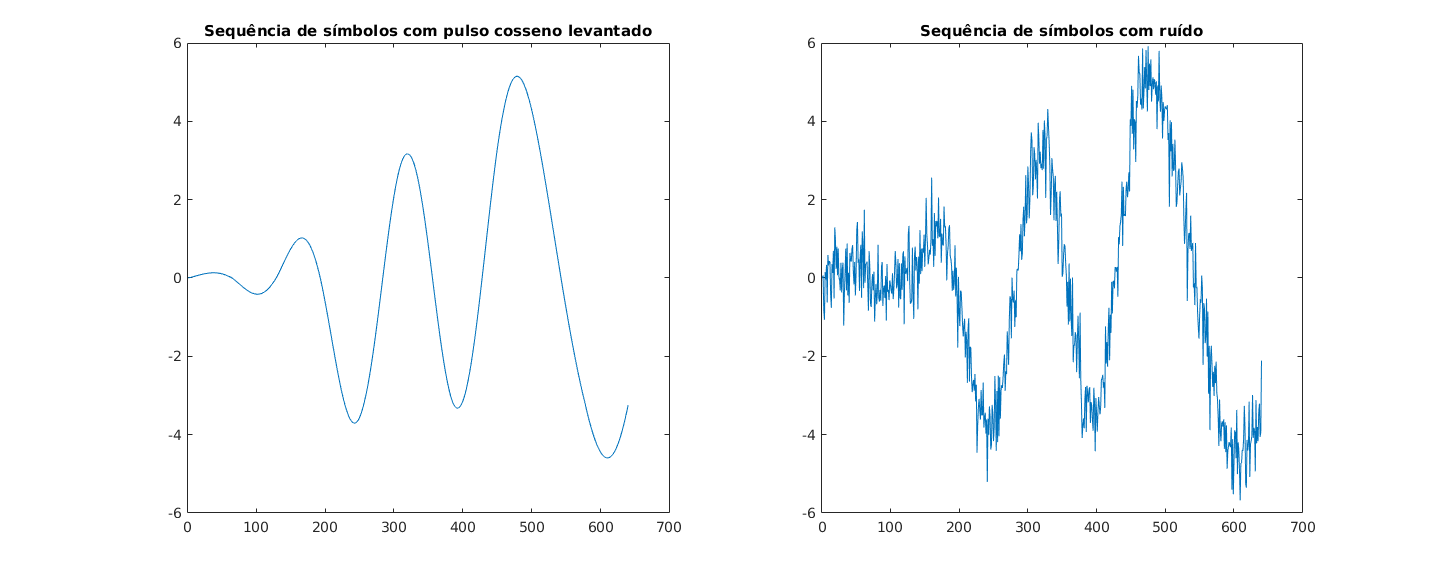

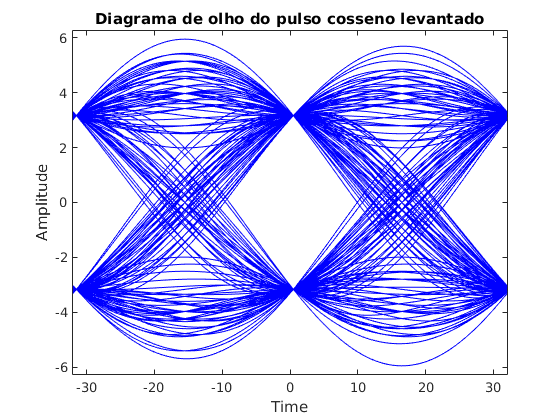

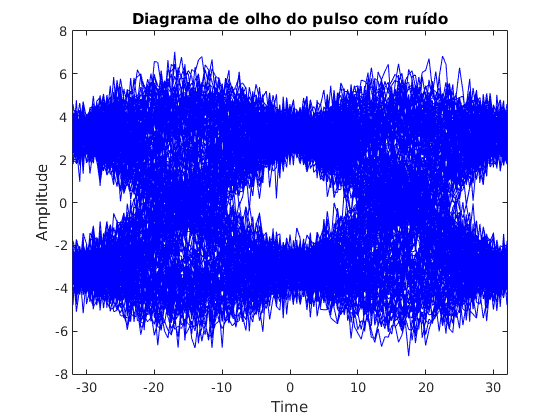

In [2]:
import matplotlib.pylab as plt
import numpy as np

peSim = 64                                        # Período do símbolo (amostras/símbolo)
nsCL = 4                                          # Número de símbolos o cosseno levantado se espalhará (ISI)
EbNo_dB = 30                                      # Eb/No da simulação (somente um valor)
EbNo = 10**(EbNo_dB/10)                           # Eb/No em escala linear
T = 0.1                                           # Tempo de símbolo (duração do símbolo em seg/símbolo)
Ts = T/64                                         # Tempo de amostragem do pulso (amostras/seg)
roff = 0.25                                       # Fator de decaimento do cosseno levantado
nSimbs = 400                                      # Número de símbolos transmitidos 
vtSim = 2*stats.randint.rvs(0, 2, size=nSimbs)-1  # Símbolos
dup = upsample(vtSim,peSim)                       # Símbolos (sobreamostragem)
hrc = np.sqrt(1/T)*rcosfir(roff, nsCL, peSim,1)
yrcosAll = np.convolve(dup,hrc)                   # Símbolos transmitidos com o cosseno levantado
yrcos = yrcosAll[2*nsCL*peSim-1:-2*nsCL*peSim] # Trem de pulso cosseno levantado

#
# Canal AWGN 
Eb = sum(np.dot(hrc, hrc.T)) / len(hrc)
No = Eb/EbNo
vtN = np.sqrt(1/Ts*No/2)*stats.norm.rand(len(yrcosAll))
# Sinal recebido com ruído AWGN
yrcosAlln = yrcosAll + vtN 
yrcosn = yrcos + vtN[2*nsCL*peSim:-2*nsCL*peSim]
#
# Diagrama de olho
eyediagram(yrcosn, 2*peSim,peSim)                  # Diagrama de olho do cosseno levantado
plt.title('Diagrama de olho do pulso com ruído')
eyediagram(yrcos, 2*peSim,peSim)                   # Diagrama de olho do cosseno levantado
plt.title('Diagrama de olho do pulso cosseno levantado')
#
# Configuração dos gráficos no tempo
nSim2Plot = 10                                     # Número de símbolos para o gráfico no tempo
plt.figure()
# gráfico pulso cosseno levantado
plt.subplot(1,2,1)
plt.plot(yrcosAll[:nSim2Plot*peSim])
title('Sequência de símbolos com pulso cosseno levantado')
plt.subplot(1,2,2)
plt.plot(yrcosAlln[:nSim2Plot*peSim])
plt.title('Sequência de símbolos com ruído')

plt.show()

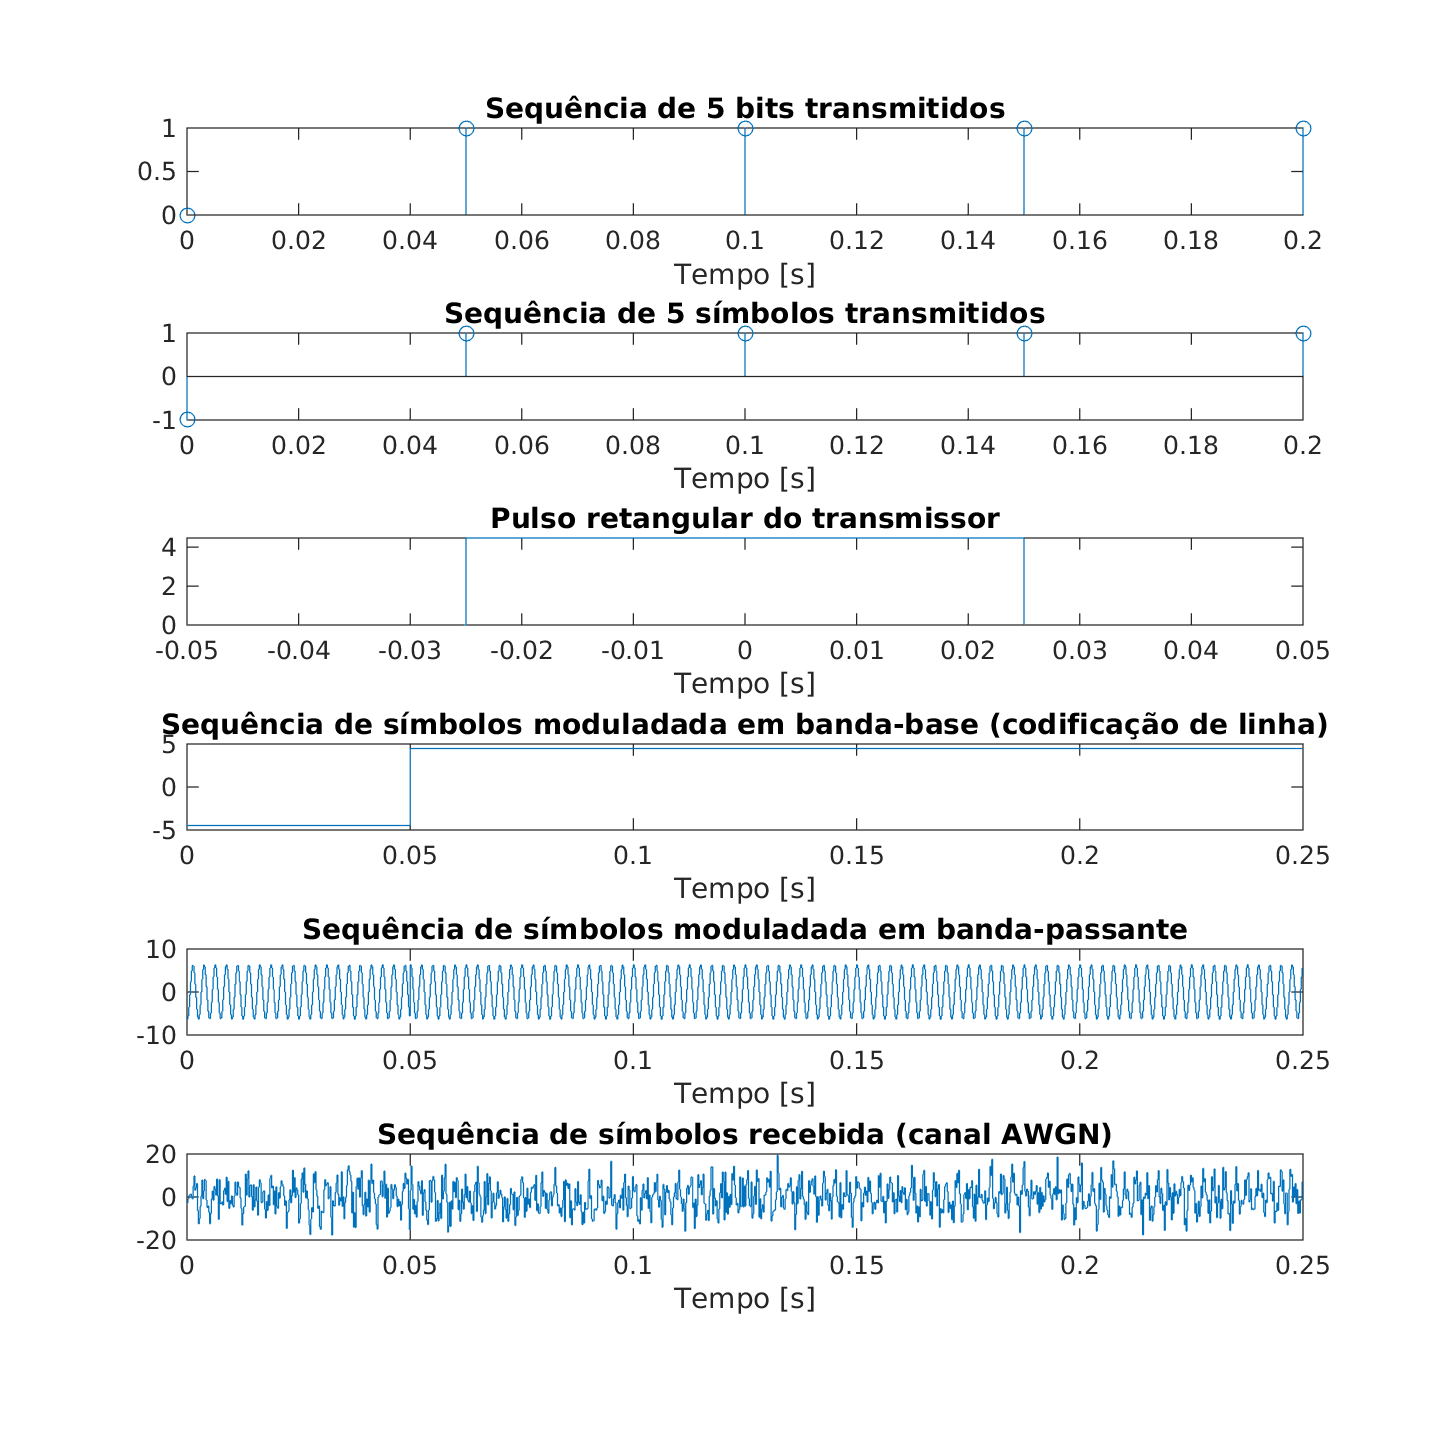

In [6]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats

def upsample(signal, rate):
    ret = np.zeros(rate*len(signal))
    ret[::rate] = signal
    return ret

# Parâmetros
EbNo_dB = 20                      # Eb/No da simulação (somente um valor)
EbNo = 10**(EbNo_dB/10)            # Eb/No em escala linear
# Transmitir 1 quadro de Na bits com nSamp amostras
Na = 1000                         # Número de bits por quadro
nAmoSim = 256                     # Número de amostras por símbolo 
T = 0.05                          # Tempo de símbolo (duração do símbolo em seg/símbolo)
Ts = T / nAmoSim                  # Tempo de amostragem do pulso (amostras/seg)
Ns = Na * nAmoSim                 # Número de amostras
t = np.arange(0, Ns)*Ts                   # Eixo do tempo 
# 
# Transmissor
vtSimbolos = [-1, 1]              # Símbolos (BPSK)
vtBin = stats.randint.rvs(0, 2, size=Na) # Vetor com bits
# Energia do bit
Eb = sum(np.dot(vtSimbolos, vtSimbolos.T)) / len(vtSimbolos)  
vtTxSim = vtSimbolos[vtBin]     # Mapeamento bit para símbolo
# Codificação de linha (modulação em banda-base)
hT = 1/np.sqrt(T)*np.ones(nAmoSim)   # Pulso retangular do transmissor (NRZ)
# Aplicando o pulso a sequência de símbolos 
vtTxBB = np.convolve(upsample(vtTxSim, nAmoSim), hT)        
vtTxBB = vtTxBB[:Ns]             # Truncando para o número de amostras original 
# Modulação em banda-passante
fc = 400                          # Frequência da portadora [Hz]
vtTxBP = vtTxBB * np.sqrt(2) * np.cos(2*np.pi*fc*t)  # Modulator (portadora de potência 1)
#
# Canal AWGN 
No = Eb/EbNo
# Sinal recebido
vtRxBP =  vtTxBP + sqrt(1/Ts*No/2)*np.stats.rand(size=len(vtTxBP)) 
#
# Gráficos
plt.figure()
nPontos = 5                      # Plotar somente os nPontos iniciais
# Bits
plt.subplot(6,1,1)
tBits = np.arange(nPontos)*Ts*nAmoSim
plt.stem(tBits,vtBin[:nPontos])
plt.title("Sequência de {} bits transmitidos".format(nPontos))
plt.xlabel('Tempo [s]')
# 
# Símbolos
plt.subplot(6,1,2)
tSim = np.arange(nPontos)*Ts*nAmoSim
plt.stem(tSim,vtTxSim[:nPontos])
plt.title("Sequência de {} bits transmitidos".format(nPontos))
plt.xlabel('Tempo [s]')
#
# Pulso
plt.subplot(6,1,3)
thT = np.arange(-nAmoSim/2, nAmoSim/2)*Ts
plt.stairs(np.hstack((thT[0]-Ts, thT, thT[-1]+Ts),np.hstack((0, hT, 0))
plt.title('Pulso retangular do transmissor')
plt.xlabel('Tempo [s]')
plt.xlim(-nAmoSim*Ts, nAmoSim*Ts)
plt.ylim(0, 1/np.sqrt(T)])
#
# Codificador de linha (modulação em banda-base)
plt.subplot(6,1,4)
tMod = np.arange(nPontos*nAmoSim)*Ts
plt.stairs(tMod,vtTxBB[:nPontos*nAmoSim])
plt.title('Sequência de símbolos moduladada em banda-base (codificação de linha)')
plt.xlabel('Tempo [s]')
#
# Modulador em banda-passante
plt.subplot(6,1,5)
plt.stairs(tMod,vtTxBP[:nPontos*nAmoSim])
plt.title('Sequência de símbolos moduladada em banda-passante')
plt.xlabel('Tempo [s]')
# Sinal recebido (canal AWGN)
plt.subplot(6,1,6)
plt.stairs(tMod,vtRxBP[:nPontos*nAmoSim])
plt.title('Sequência de símbolos recebida (canal AWGN)')
plt.xlabel('Tempo [s]')

plt.show()

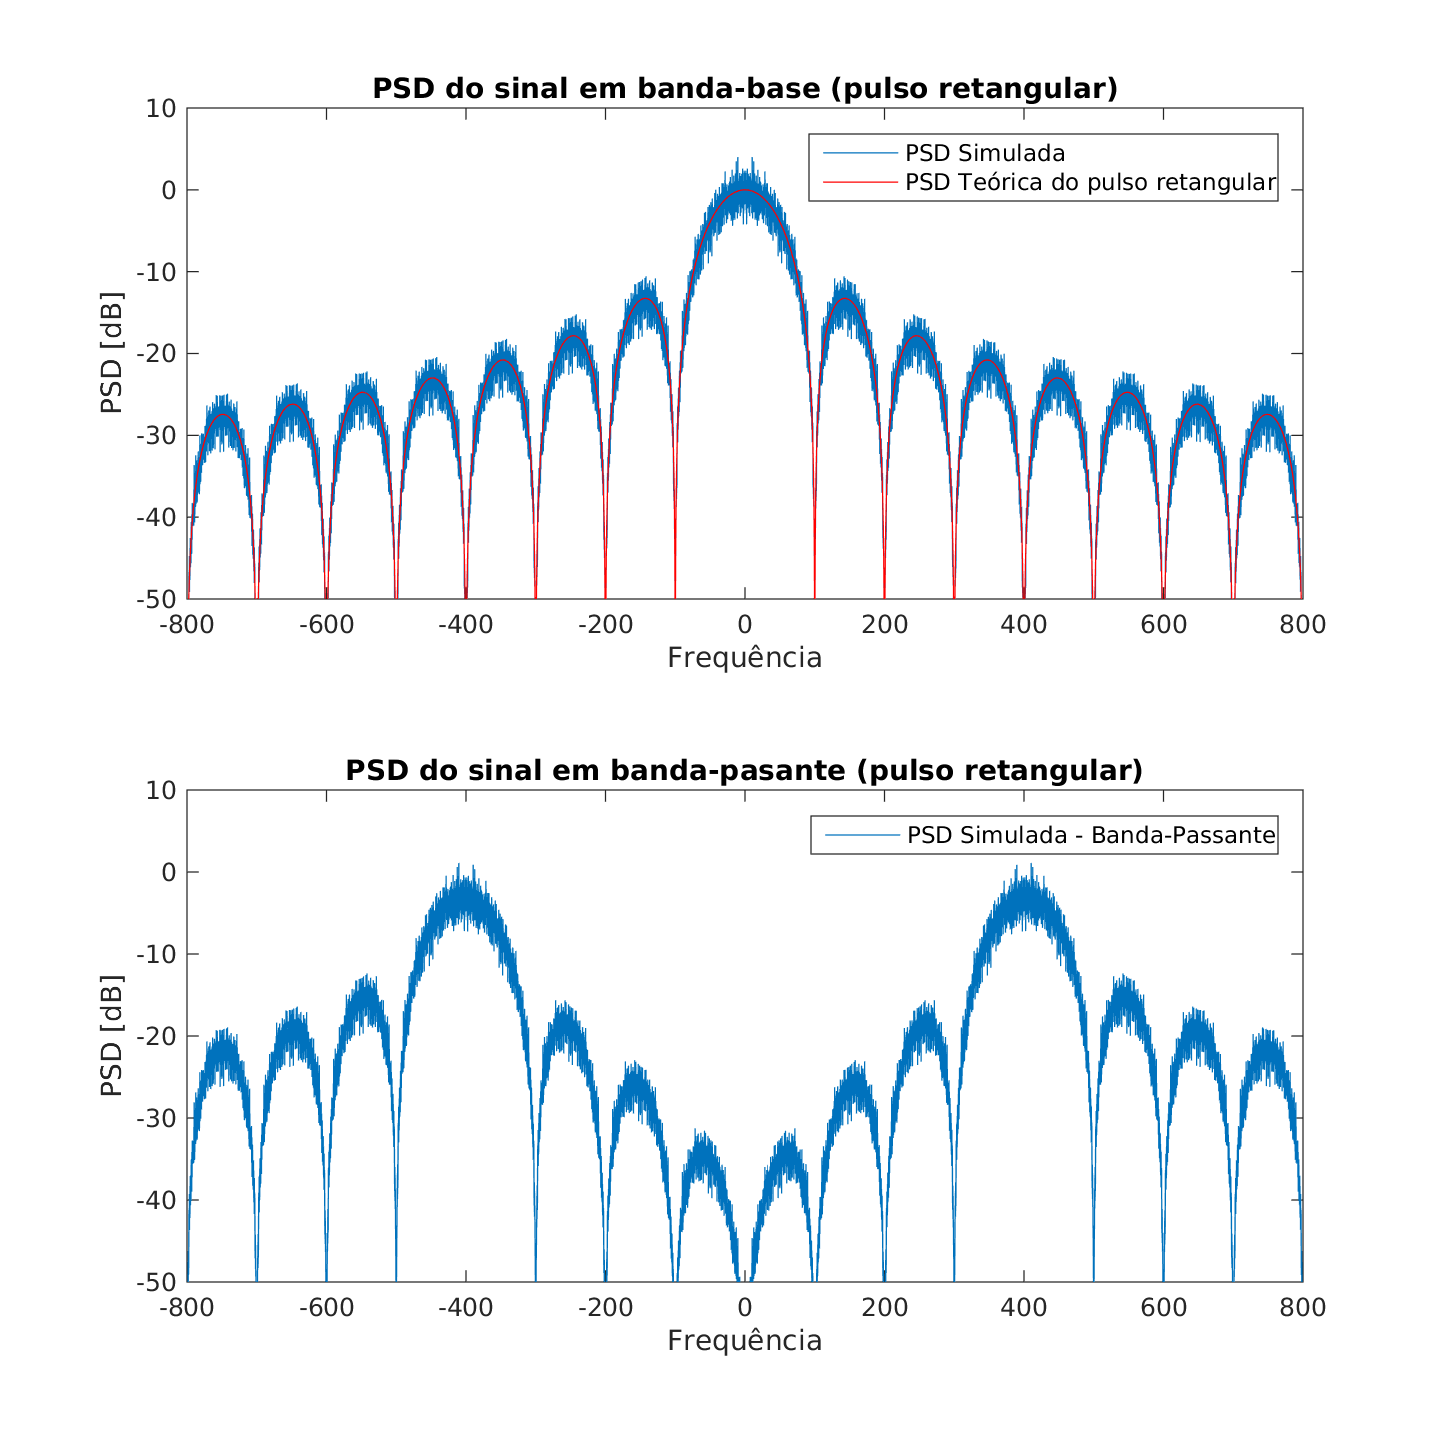

In [11]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats

def upsample(signal, rate):
    ret = np.zeros(rate*len(signal))
    ret[::rate] = signal
    return ret

EbNo_dB = 20                      # Eb/No da simulação (somente um valor)
EbNo = 10**(EbNo_dB/10)            # Eb/No em escala linear
# Transmitir Nf quadros de Na bits com nSamp amostras
Nf = 10                           # Número de quadros a simular
Na = 1000                         # Número de bits por quadro
nAmoSim = 128                     # Número de amostras por símbolo
T = 0.01                          # Tempo de símbolo (duração do símbolo em seg/símbolo)
Ts = T / nAmoSim                  # Tempo de amostragem do pulso (amostras/seg)
Ns = Na * nAmoSim                 # Número de amostras
fc = 400                          # Frequência da portadora [Hz] - modulação em banda-passante
t = np.arange(Ns)*Ts              # Eixo do tempo
vtPSDSimBB = np.zeros(Ns)         # Vetor com a PSD simulada (estimada nos Nf quadros)-Banda-base
vtPSDSimBP = np.zeros(Ns)         # Vetor com a PSD simulada (estimada nos Nf quadros)-Banda-passante
#
# Transmissor
vtSimbolos = np.array([-1, 1])                   # Símbolos (BPSK)

for _ in range(Nf):                             # Loop para cada quadro
    #
    vtBin = stats.randint.rvs(0, 2, size=Na) # Vetor com bits
    # Energia do bit
    Eb = np.sum(np.dot(vtSimbolos, vtSimbolos.T)) / len(vtSimbolos)
    vtTxSim = vtSimbolos[vtBin]     # Mapeamento bit para símbolo
    # Codificação de linha (modulação em banda-base)
    hT = 1/np.sqrt(T)*np.ones(nAmoSim)   # Pulso retangular do transmissor (NRZ)
    # Aplicando o pulso a sequência de símbolos (sinal em banda-base)
    vtTxBB = np.convolve(upsample(vtTxSim, nAmoSim), hT)
    vtTxBB = vtTxBB[:Ns]             # Truncando para o número de amostras original
    # Modulação em banda-passante (portadora com potência 1)
    vtTxBP = vtTxBB * np.sqrt(2) * np.cos(2*np.pi*fc*t)  
    #
    # Estimação da PSD via fft (sinal em banda-base)
    vtSpecBB = fftshift(fft(vtTxBB))
    # PSD do sinal em banda-base
    vtPSDSimBB = vtPSDSimBB + (vtSpecBB*np.conj(vtSpecBB) * Ts / Ns) 
    # Calcula a estimativa da PSD do sinal em banda-passante
    vtSpecBP = fftshift(fft(vtTxBP))
    vtPSDSimBP = vtPSDSimBP + (vtSpecBP*np.conj(vtSpecBP) * Ts / Ns) 
#
# Gráficos da PSD do sinal em banda-base
plt.figure()
plt.subplot(2,1,1)
xFreq = np.arange(-1/(2*Ts), 1/(Ns*Ts), 1/(2*Ts)-(1/(Ns*Ts)))
# PSD teórica do pulso rentangular
VfTheo = (1/sqrt(T))*(T*np.sinc(T*xFreq))
PSDTheo = VfTheo**2/T
# PSD estimada pelas amostras do sinal
plt.plot(xFreq,10*log10(vtPSDSimBB/Nf))
# PSD teórica
plt.plot(xFreq,10*np.log10(PSDTheo),'r')
title('PSD do sinal em banda-base (pulso retangular)')
legend('PSD Simulada','PSD Teórica do pulso retangular')
xlabel('Frequência')
ylabel('PSD [dB]')
plt.xlim(-2*fc, 2*fc)
plt.ylim(-50, 10)
# Gráficos da PSD do sinal em banda-passante
plt.subplot(2,1,2)
# PSD estimada pelas amostras do sinal 
plt.plot(xFreq,10*np.log10(vtPSDSimBP/Nf))
plt.title('PSD do sinal em banda-pasante (pulso retangular)')
plt.legend('PSD Simulada - Banda-Passante')
plt.xlabel('Frequência')
plt.ylabel('PSD [dB]')
plt.xlim(-2*fc, 2*fc)
plt.ylim(-50, 10)

plt.show()

Rodando Eb/No = -10 dB
Rodando Eb/No = -8 dB
Rodando Eb/No = -6 dB
Rodando Eb/No = -4 dB
Rodando Eb/No = -2 dB
Rodando Eb/No = 0 dB
Rodando Eb/No = 2 dB
Rodando Eb/No = 4 dB
Rodando Eb/No = 6 dB
Rodando Eb/No = 8 dB
Rodando Eb/No = 10 dB


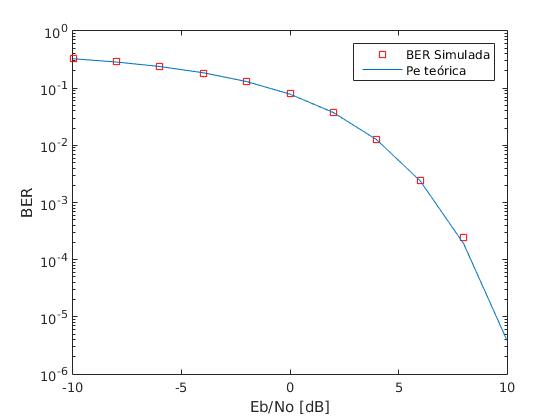

In [14]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats

def qfunc(x):
    return 0.5-0.5*scipy.special.erf(x/np.sqrt(2))

def upsample(signal, rate):
    ret = np.zeros(rate*len(signal))
    ret[::rate] = signal
    return ret

# Parâmetros
vtEbNodB = np.arange(-10, 2, 10)            # Eb/No da simulação (somente um valor)
vtEbNo = 10**(vtEbNodB/10)       # Eb/No em escala linear
# Transmitir Nf quadros de Na bits com nSamp amostras
Nf = 100
Na = 1000                         # Número de bits por quadro
nAmoSim = 128                     # Número de amostras por símbolo
T = 0.01                           # Tempo de símbolo (duração do símbolo em seg/símbolo)
Ts = T / nAmoSim                  # Tempo de amostragem do pulso (amostras/seg)
Ns = Na * nAmoSim                 # Número de amostras
fc = 400                          # Frequência da portadora [Hz] - modulação em banda-passante
t = np.arange(Ns)*Ts                   # Eixo do tempo
# Pulso (retangular) da modulação em banda-base (codificação de linha)
hT = 1/np.sqrt(T)*np.ones(nAmoSim)   # Pulso retangular do transmissor (NRZ)
# Pulso do filtro casado do receptor
hR = fliplr(hT)                   
#
# Transmissor
vtSimbolos = np.array([-1, 1])               # Símbolos (BPSK)
# Energia do bit
Eb = np.sum(np.dot(vtSimbolos, vtSimbolos.T)) / len(vtSimbolos)
#
for ni in range(vtEbNo):                       # Loop para cada Eb/No
    print('Rodando Eb/No = {} dB'.format(vtEbNodB[ni]))
    nErrs = 0                                  # Contador do número de bits errados
    No = Eb/vtEbNo[ni]                         # Potência do ruído
    for i in range(Nf):                                  # Loop para cada quadro
        #
        vtBin = stats.randint.rvs(0, 2, size=Na) # Vetor com bits 
        vtTxSim = vtSimbolos[vtBin]          # Mapeamento bit para símbolo
        # Modulação em banda-base
        # Aplicando o pulso a sequência de símbolos (sinal em banda-base)
        vtTxBB = np.convolve(upsample(vtTxSim, nAmoSim), hT)
        vtTxBB = vtTxBB[:Ns]                  # Truncando para o número de amostras original
        # Modulação em banda-passante (portadora com potência 1)
        vtTxBP = vtTxBB * np.sqrt(2) * np.cos(2*np.pi*fc*t)
        #
        # Sinal recebido (anal AWGN)
        vtRxBP =  vtTxBP + np.sqrt(1/Ts*No/2)*stats.rand.rvs(size=len(vtTxBP))
        #
        # Receptor
        vtBB = vtRxBP* np.sqrt(2)*np.cos(2*np.pi*fc*t) # Demodulador banda-passante
        vtFC = np.convolve(vtBB, hR) * Ts              # Filtro Casado (demodulação em banda-base)
        r = vtFC[np.arange(Na)*nAmoSim]                # Downsample (amostragem antes do decisor)
        vtBinRec = (r > 0.0)                    # Decisor BPSK
        # Contagem de erros
        nErrs = nErrs + np.sum(np.bitwise_xor(vtBin, vtBinRec))
    # BER (simulada)
    vtBER[ni] = nErrs/(Na*Nf)
    vtPe[ni] = qfunc(np.sqrt(2*vtEbNo[ni]))
# 

# Gráfico BER vs Eb/No and Pe vs Eb/No
plt.figure()
plt.semilogy(vtEbNodB, vtBER, 'sr')
plt.semilogy(vtEbNodB, vtPe)
plt.legend('BER Simulada','Pe teórica')
plt.xlabel('Eb/No [dB]')
plt.ylabel('BER')
plt.show()